In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Executive summary

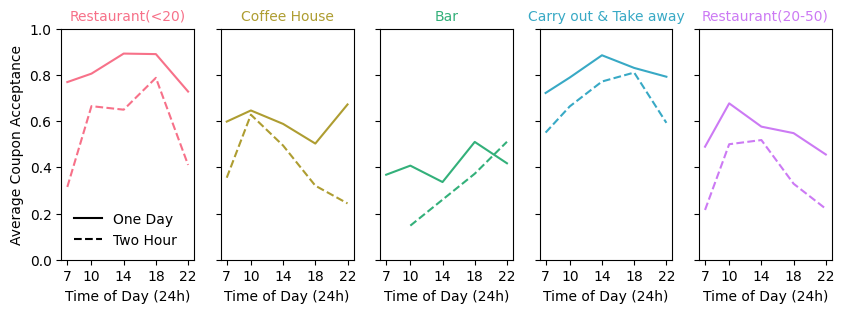

The following notebook includes an exploration of data concerning coupon acceptance rates for drivers in different scenarios and across different categories. The analysis explores the impact of coupon type, patronage frequency, distance to an establishment, time of day, coupon expiration, and income of recipient. 

We find that the coupon campaign is most successful for coupons for (1) carry out orders and (2) restaurants that cost less than $20. Campaigns for both of these types are robust to both the frequency of patronage and the time of day, achieving acceptance rates upwards of 70% across subcategories. When only 1-day coupons are considered for these categories, extremely strong acceptance rates of 80-90% are achieved. 

There is more variability in acceptance rates for the other coupon types, *viz.* (3) restuarants $20-50, (4) coffee houses, and (5) bars. Here, too, one-day coupons have higher success rates in almost all circumstances. Still, even when only one-day coupons are considered, acceptance rates are generally in the 40-60% range for these categories. 

Further analysis of the data for category (3) indicates that there are sub-cohorts of coupon recipients with higher acceptance rates. For instance, those who usually patronize this type of establishment more than once a month are have higher acceptance rates than other participants. When only this cohort is considered, recipients are about 80% likely to accept coupons for establishments less than 15 minutes away, a significant improvement. This finding illustrates that, even in coupon categories where overall acceptance is lower, a targeted campaign may enjoy high success rates and generate customer traffic. 

On the basis of this analysis, we recommend coupon campaigns for carry out and cheaper (<$20 per person) restaurants, where 1-day coupons have extremely high use rates. For other coupon categories, more targeted analyses, like the one indicated above, are necessary to optimize campaigns. 

# Data cleaning

In [218]:
all_data = pd.read_csv('data/coupons.csv')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

First, we fix a typo and spell "passenger" correctly:

In [219]:
all_data.rename({'passanger': 'passenger'}, axis=1, inplace=True)

The `car` descriptor only has 108 non-null entries, so this is not likely to be very informative for our data analysis. We'll drop it from the data set and create a new working data frame, `df`:

In [220]:
df = all_data.drop('car', axis=1)

A number of the other descriptors (`Bar`, `CoffeeHouse`, `CarryAway`, `RestaurantLessThan20`, and `Restaurant20To50`) have a few missing data points, but are generally complete. For these, we can see that there are a total of 605 entries where at least one descriptor is missing: 

In [221]:
len(df[df.Bar.isna() | df.CoffeeHouse.isna() | df.CarryAway.isna() | 
       df.RestaurantLessThan20.isna() | df.Restaurant20To50.isna()])

605

This is about 5% of the total data, and we should still have a robust set without these entires in it. Dropping these gives us

In [222]:
df = df[df.Bar.notna() & df.CoffeeHouse.notna() & df.CarryAway.notna() & 
        df.RestaurantLessThan20.notna() & df.Restaurant20To50.notna()]

print(f"Are there NA values? {df.isna().any().any()}") # Confirming all NaNs were removed
print(f"Data shape: {df.shape}") # Determining remaining rows

Are there NA values? False
Data shape: (12079, 25)


There are three features that correspond to the distance the driver is from the establishment offering the coupon, specifically `toCoupon_GEQ5min`, `toCoupon_GEQ15min`, `toCoupon_GEQ25min`. This is a clunky way to handle the distance to the coupon, and we replace these with a `distance` column that takes on values of 0, 5, 15, or 25, representing the lower bound of the distance to the establishment.

In [223]:
def get_distance_from_idx(idx):
    if idx == 0:
        return 0
    if idx == 1:
        return 5
    if idx == 2:
        return 15
    if idx == 3:
        return 25
    
exp_rest['distance_idx'] = exp_rest[['toCoupon_GEQ5min','toCoupon_GEQ15min', 'toCoupon_GEQ25min']].sum(axis=1)
exp_rest['distance'] = exp_rest['distance_idx'].apply(get_distance_from_idx)

# Exploratory data analysis: Overall trends

We begin the exploration of our dataset by determining the total number of coupons offered and accepted for each coupon type. For clarity, we include an annotation with the percent acceptance for each class of coupon:

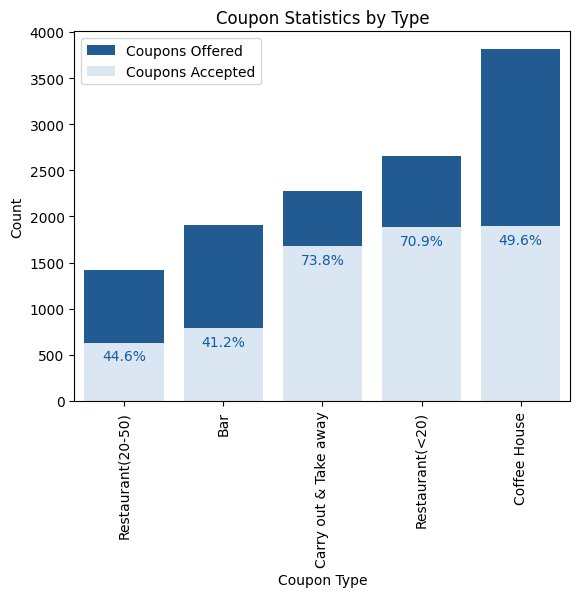

In [224]:
acceptance_stats = df.groupby('coupon')[['Y']].agg({'Y': ['sum','mean','count']}).sort_values(('Y','count'))
annotations = [f"{ann*100:0.1f}%" for ann in acceptance_stats[('Y', 'mean')]]
palette = sns.color_palette('Blues',5)

ax = sns.barplot(x=acceptance_stats.index, y=acceptance_stats[('Y', 'count')], color=palette[4], label='Coupons Offered')
sns.barplot(x=acceptance_stats.index, y=acceptance_stats[('Y', 'sum')], color=palette[0], label='Coupons Accepted')
ax.bar_label(ax.containers[-1], annotations, padding=-15, color=palette[4], size=10)
ax.set_ylabel("Count")
ax.set_xlabel("Coupon Type")
ax.set_title("Coupon Statistics by Type")
plt.legend(loc='upper left')
plt.xticks(rotation=90);

It's immediately obvious that coupons for (1) carry out orders and (2) less expensive restaurants generally have higher success rates than the other categories.

## Impact of patronage frequency

For each coupon type, there is a corresponding feature for how frequently the participant goes to the corresponding type of establishment. It is of interest to consider how this impacts the campaign success rate across the coupon types. To do this, we need to created a DF with a `frequency` column that corresponds to the frequency a participant typically patrons the type of establishment *that corresponds with* the coupon type. We do this as follows, aggregating as we go, and storing the result to `plot_df`.

In [225]:
column_selector = {'Restaurant(<20)': 'RestaurantLessThan20', 
                   'Coffee House': 'CoffeeHouse', 
                   'Carry out & Take away': 'CarryAway', 
                   'Bar': 'Bar',
                   'Restaurant(20-50)': 'Restaurant20To50'}
frequency_map = {'1~3': '1-3', 
              '4~8': '4-8', 
              'gt8': '>8', 
              'less1': '<1', 
              'never': 'Never'}

plot_df = pd.DataFrame()
for coupon_type in df.coupon.unique():
    column = column_selector[coupon_type]
    subset_df = df.query("coupon == @coupon_type")[['coupon', column, 'Y']]
    subset_df.rename({column: 'frequency'}, axis=1, inplace=True)
    grouped_subset = subset_df.groupby('frequency').agg({'coupon': 'first', 'Y': 'mean'}).reset_index()
    grouped_subset['Y'] = grouped_subset['Y'] * 100
    grouped_subset['frequency'] = grouped_subset['frequency'].apply(lambda x: frequency_map[x])
    plot_df = pd.concat((plot_df, grouped_subset))

Now we generate a bar plot of the percent acceptance as a function of both the coupon type and the patronage frequency.

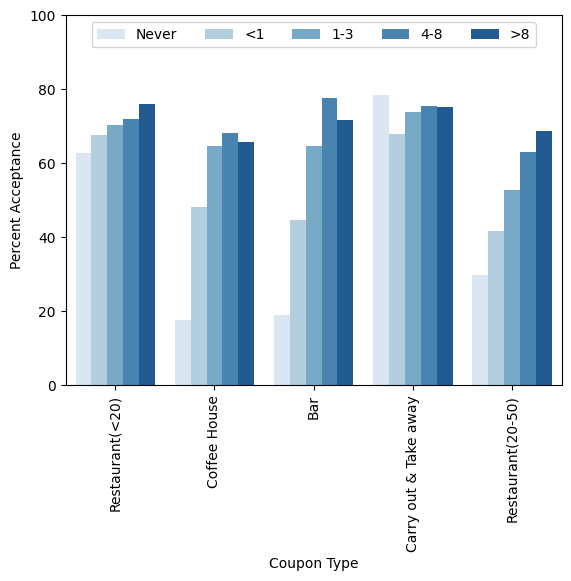

In [226]:
order = ['Never', '<1', '1-3', '4-8', '>8']
ax = sns.barplot(data=plot_df, x='coupon', y='Y', hue='frequency', hue_order=order, palette='Blues')

plt.ylim(0,100)
plt.ylabel("Percent Acceptance")
plt.xticks(rotation=90)
plt.xlabel("Coupon Type")

plt.legend(ncols=5, loc='upper center');

There are some interesting trends and differences to note here. First, in most cases, the liklihood of accepting a coupon increases with the frequency that a participant typically patronizes an establishment of a given type. Notably, in comparison with the results from the preceding plot, we can see that this effect is the most dramatic for the establishment types that had the lowest overall acceptance rate. On the other hand, for less expensive restaurants and carry out orders, this trend was more muted, especially in the latter case where there seems to be no correlation at all. 

It's also worth noting that, among participants who patronize a certain type of establishment frequently, coupons of that type are approximately equally effective. The difference, then, lies in the willingness (or lack thereof) of a coupon recipient to patronize an establishment type that they do not usually visit. 

## Impact of time of day

As can be seen below, the time of day has more significant impacts for certain categories than others. Specifically, early-morning and late-night coupon offers for dine-in restaurants have lower use rates than those at other times in the day. Likewise, mid-morning and early-afternoon offers were most successful for coffee shop coupons. 

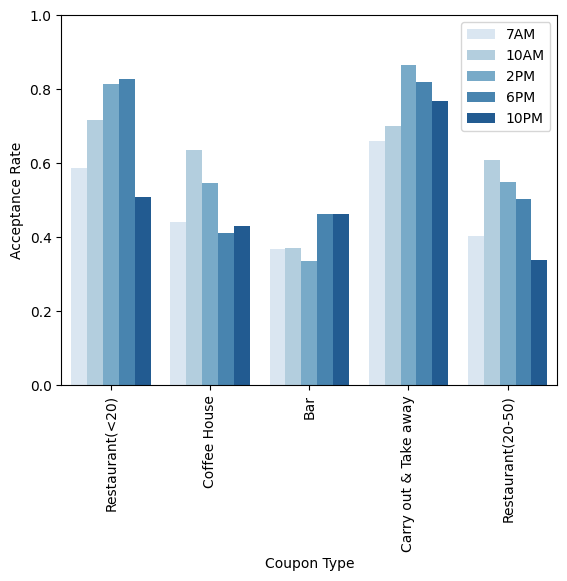

In [227]:
order = ['7AM', '10AM', '2PM', '6PM', '10PM']
ax = sns.barplot(data=df, x='coupon', y='Y', hue='time', hue_order=order, palette='Blues', errorbar=None)
plt.xticks(rotation=90)
plt.ylim(0,1)
ax.legend_.set_title("")
plt.ylabel("Acceptance Rate")
plt.xlabel("Coupon Type");

Trends in the preceding plot can be used to optimize coupon campaigns. For instance, restaurant coupons are most successful when issued between the hours of 10am and 6pm, while those issued at 10pm are particularly unsuccessful. Similarly, mid-morning and early afternoon have the highest success rates for coffee house coupons. 

It's reasonable to expand the time-of-day to include information about coupon expiration time. One could imagine, for instance, that a 2-hour coupon for a bar issued at 10AM is less likely to be accepted than a 24-hour coupon issued at the same time, simply becaue fewer people frequent bars in the morning. We'll explore this by comparing acceptance of coupon expirations by type throughout different hours of the day.

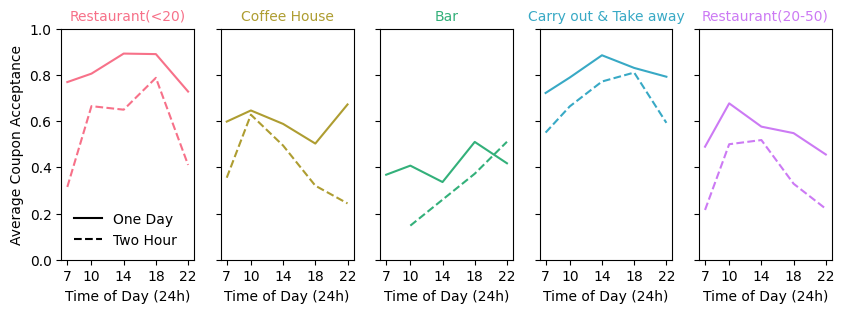

In [379]:
def get_24_time(t):
    if 'AM' in t:
        return int(t.replace('AM',''))
    if 'PM' in t:
        return int(t.replace('PM','')) + 12
    else:
        return int(t)

df_24hour = df.copy()
df_24hour['time'] = df_24hour['time'].apply(get_24_time)
plot_data = df_24hour.groupby(['coupon','time','expiration'])['Y'].mean().reset_index()
one_day  = plot_data.query("expiration == '1d'")
two_hour = plot_data.query("expiration == '2h'")

fig, axs = plt.subplots(1,6, figsize=(12,3), sharey=True, sharex=True)
axs = axs.flatten()
palette = sns.color_palette('husl', len(df_24hour.coupon.unique()))

plt.ylim(0,1)
plt.xticks(one_day.time.unique())

for idx, coupon in enumerate(df_24hour.coupon.unique()):
    ax = axs[idx]
    c = palette[idx]
    sns.lineplot(data=one_day.query("coupon == @coupon"), x='time', y='Y', ax=ax, color=c, label='One Day')
    sns.lineplot(data=two_hour.query("coupon == @coupon"), x='time', y='Y', ax=ax, color=c, 
                 label='Two Hour', linestyle='--')
    ax.set_title(f"{coupon}", color=c, size=10)
    ax.set_xlabel("Time of Day (24h)")
    
    if idx != 0:
        ax.legend_.remove()
    else:
        leg = ax.legend_
        leg.set_frame_on(False)
        for line in leg.get_lines():
            line.set_color('k')
        

axs[0].set_ylabel("Average Coupon Acceptance")
axs[5].remove()

plt.savefig('images/coupon_time_expiration.png', bbox_inches='tight');

Here, we can see that for almost all coupon types at almost all times, one-day coupons have a higher acceptance rate than two-hour coupons. Indeed, for the highest acceptance categories noted above (cheaper restaurants and carry out orders), one-day coupons approach 90% acceptance rates at certain times of day.

**Bar.** Similarly, while bar coupons perform poorly across times and expirations, we can see that two-hour coupons perform particularly poorly when offered before 6PM, and that there is a marginal crossover where two-hour coupons actually outperform one-day coupons at 10PM. 

**Coffee House.** We saw previously that coffee house coupons had the highest acceptance rates during early afternoon and mid-morning overall. With this level of analysis, however, we can see that this mostly due to low performance of two-hour coupons issued later in the day. By contrast, one-day coupons in this cateogry perform similarly at all times of day, and actually reach their highest acceptance rates when issued at 10PM. 

# Exploratory data analysis: Specific coupon types

As noted above, success rates for certain types of coupons are stable across the frequency a customer visits a type of establishment and the time of day. Others exhibit more variability, specifically including (1) expensive restaurants, (2) coffee houses, and (3) bars. We will examine one of these categories at a deeper level to identify targets for the most successful ad campaign. 

## Expensive restaurants

We already saw that 2-hour coupons for expensive restaurants were generally unsuccessful, so we will drop these from our analysis, considering only performance of 1-day coupons in this category. We also saw that those who did not frequent expensive restaurants were unlikely to accept these coupons, so we will also filter the dataset to only include participants who report going to expensive restaurants at least once a month. 

In [229]:
exp_rest = df.copy().query("coupon == 'Restaurant(20-50)' and expiration == '1d' \
                            and Restaurant20To50 not in ['less1','never']")
exp_rest.sample(2)

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
12669,No Urgent Place,Partner,Sunny,30,10AM,Restaurant(20-50),1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
9699,Home,Alone,Sunny,80,10PM,Restaurant(20-50),1d,Male,41,Married partner,...,never,gt8,1~3,1~3,1,1,0,0,1,1


First we consider the impact of the distance of the restaurant on the participant, and whether the restaurant is in the same or the opposite direction. 

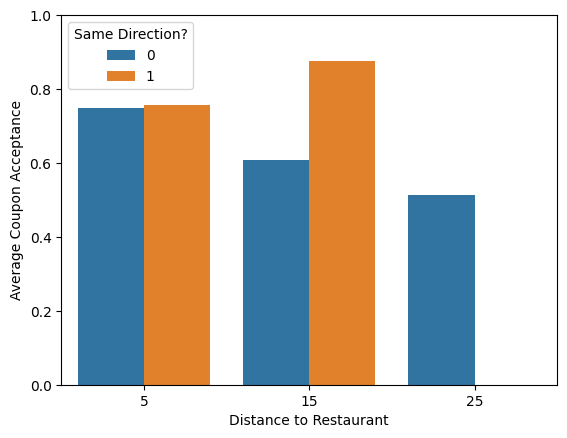

In [283]:
ax = sns.barplot(data=exp_rest, x='distance', y='Y', hue='direction_same', errorbar=None)
ax.set_xlabel("Distance to Restaurant")
ax.set_ylabel("Average Coupon Acceptance")
ax.legend_.set_title("Same Direction?")
plt.ylim(0,1);

We can see that distance to the restaurant significantly impacts the likelihood of accepting a coupon. This is somewhat interesting given that we are only considering 1-day coupons here, so participants could in theory make a separate trip. Interestingly, we have no data for restaurants far away, in the same direction, and meeting the previous selection criteria. Additional data collection that includes data of these types would be useful for future analysis.

Nonetheless, we'll narrow our focus to participatnts who are less than 25 minutes away from the restaurant.

In [288]:
exp_rest_close = exp_rest.query("distance < 25").copy()

Finally, we consider the impact of income on this cohort of participants. In order to facillitate numerical computations on income, we convert the string based values into integers representing the lower band of the income bracket. For incomes <12,500, we use 0. 

In [291]:
def get_int_income(i):
    if 'More' in i:
        return int(i.split()[0][1:])
    elif 'Less' in i:
        return 0
    else:
        return int(i.split('-')[0][1:])
    
exp_rest_close['income_lower'] = exp_rest_close.income.apply(get_int_income)

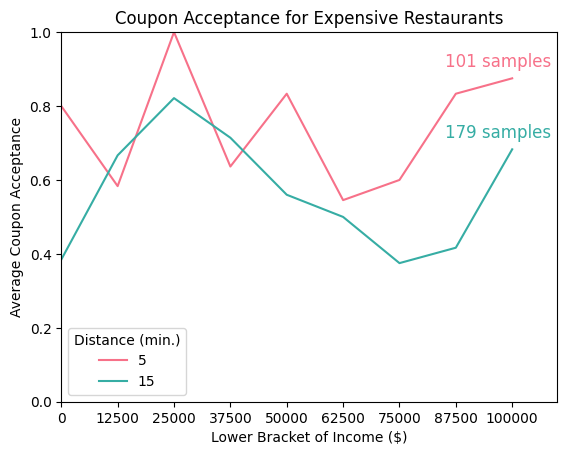

In [363]:
palette = sns.color_palette('husl',2)
plot_data = exp_rest_close.groupby(['income_lower','distance'])['Y'].agg(['count','mean']).reset_index()
ax = sns.lineplot(data=plot_data, x='income_lower', y='mean', hue='distance', palette=palette)
plt.ylim(0,1)
plt.xticks(exp_rest.income_lower.unique())

plt.ylabel("Average Coupon Acceptance")
plt.xlabel("Lower Bracket of Income ($)")
plt.title("Coupon Acceptance for Expensive Restaurants")
plt.xlim(0, 110000)

ax.legend_.set_title("Distance (min.)")

# Add annotations for total number of instances
anns = (plot_data.sort_values('income_lower')
                 .groupby('distance')
                 .agg({'mean': 'last', 'count': 'sum'})
                 .values)

for idx, ann in enumerate(anns):
    y, s = ann
    x = 85000 
    plt.annotate(f"{int(s)} samples", (x, y+0.03), color=palette[idx], size=12)

Here we can see cohorts where the acceptance for coupons is over 80%. Specifically, with all the qualifiers above (1-day coupons, those that usually eat at expensive restaurants once a month), we find that the greatest success is obtained when the restaurant is within five minutes. It is difficult to identify trends for this curve, as there is some irregularity in the data, potentially due to noise. 

The behavior is smoother for restaurants 15 minutes away, where there are about twice as many samples meeting these criteria. Here we can see an interesting (sinusoidal) relationship with income, where there is a peak in the middle-lower brackets, and then finally an increase when moving to the highest income brackets. 

**Taken together**, the preceding analysis indicates that the optimal targets for coupons to expensive restaurants satisfy the following criteria:

- They visit expensive restaurants at least once a month
- They are given coupons with an expiration of 1-day, rather than 2-hours
- They are within 5 minutes of the restaurant 